# Multinomial Simpson Paradox

this notebook shows a model for a multinomial Simpson paradox.

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

### Building the models


In [2]:
# building a model including a Simpson's paradox
import scipy.stats as stats

bn=gum.fastBN(f"A[0,99]->B[0:40:200]<-C[0,5]->A")

bn.cpt("C").fillFromDistribution(stats.uniform,loc=0,scale=5)
bn.cpt("A").fillFromDistribution(stats.uniform,loc="C*12",scale=30)
bn.cpt("B").fillFromDistribution(stats.norm,loc="5+C*4-int(A/8)",scale=2);

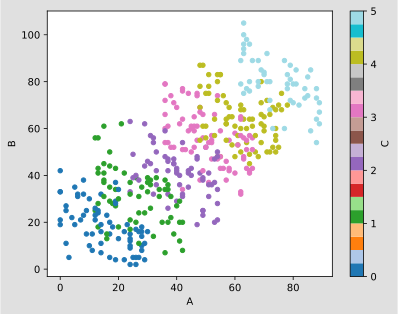

In [3]:
#  generating a CSV, taking this model as the causal one.
gum.generateSample(bn,400,"out/sample.csv",with_labels=False)
df=pd.read_csv("out/sample.csv")
df.plot.scatter(x='A', y='B', c='C',colormap="tab20");

In [4]:
cm=csl.CausalModel(bn)
_,p,_=csl.causalImpact(cm,on="B",doing="A")

In [5]:
# building an Markov-equivalent model, generating a CSV, taking this model as the causal one.
bn2=gum.BayesNet(bn)
bn2.reverseArc("C","A")

gum.generateSample(bn2,400,"out/sample2.csv",with_labels=False)
df2=pd.read_csv("out/sample2.csv")

cm2=csl.CausalModel(bn2)
_,p2,_=csl.causalImpact(cm2,on="B",doing="A")

### The observationnal model and its paradoxal structure (exactly the same with the second Markov-equivalent model)


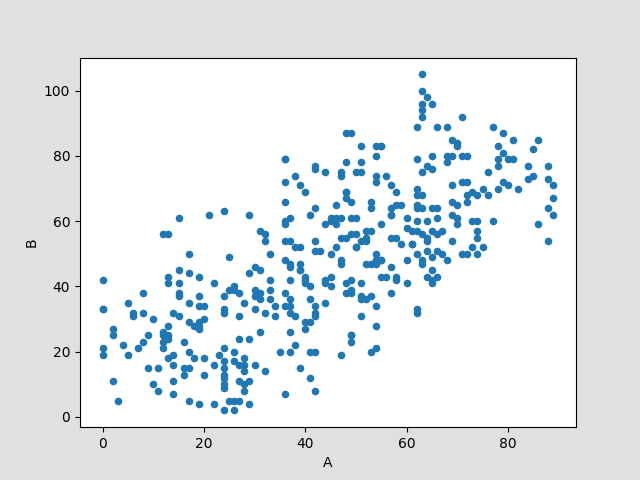
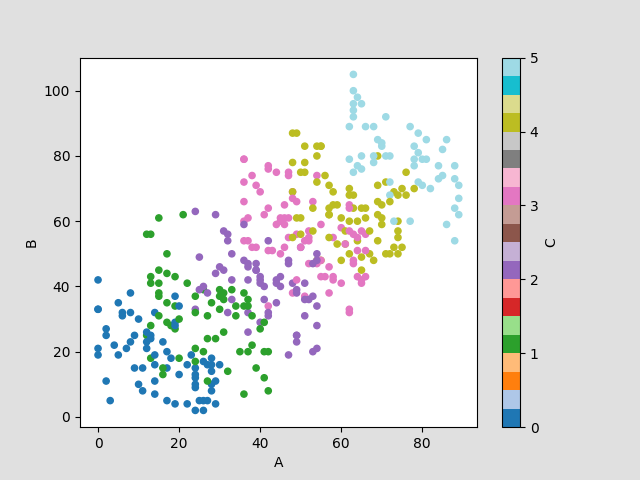


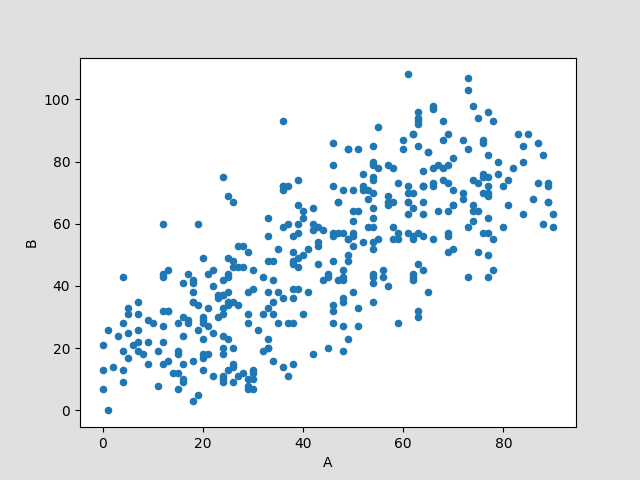
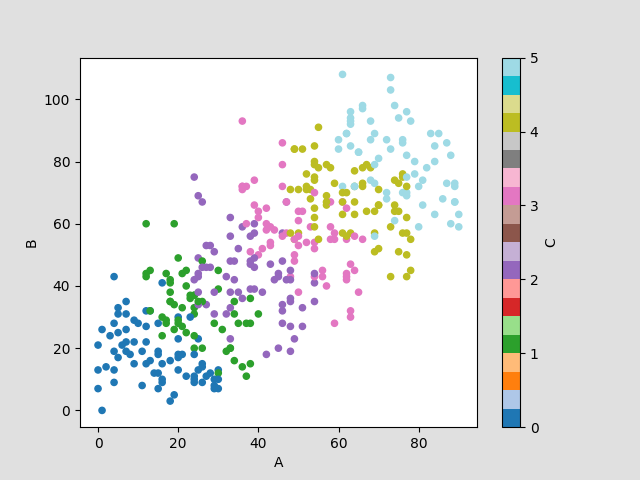

In [6]:
gnb.flow.row(gnb.getBN(bn),
             df.plot.scatter(x='A', y='B'),
             df.plot.scatter(x='A', y='B', c='C',colormap="tab20"),
             captions=["the observationnal model","the trend is increasing","the trend is decreasing for any value for C !"])
gnb.flow.row(gnb.getBN(bn2),
             df2.plot.scatter(x='A', y='B'),
             df2.plot.scatter(x='A', y='B', c='C',colormap="tab20"),
             captions=["the Markov-equivalent model","the trend is increasing","the trend is decreasing for any value for C !"])

### The paradox is revealed in the trend of the inferred means : the means are increasing with the value of $A$ **except for any value of $C$** ...

In [7]:
gum.config["notebook","histogram_epsilon"]=0.001
gum.config['notebook', 'histogram_discretized_scale']=0.4


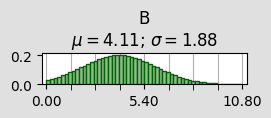
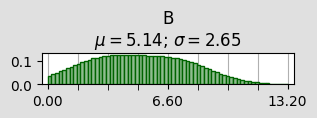
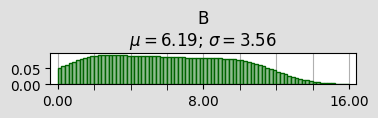
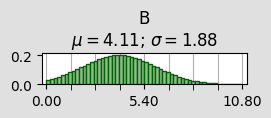
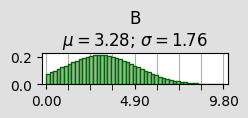
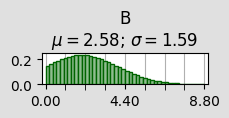
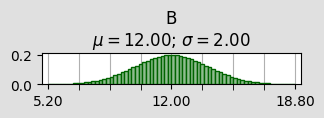
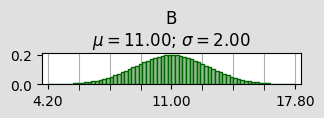
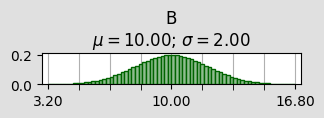
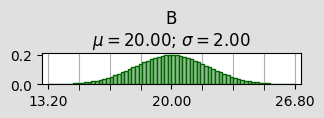
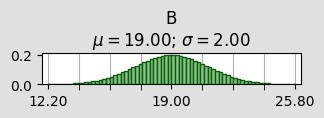
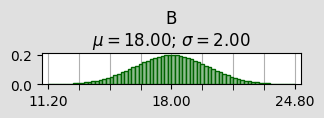

In [8]:
for a in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":a}),f"$P(B|A={a})$")
gnb.flow.new_line()
for a in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":a,"C":0}),f"P(B | $A={a},C=0)$")
gnb.flow.new_line()
for a in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":a,"C":2}),f"P(B | $A={a},C=2$)")
gnb.flow.new_line()
for a in [10,20,30]:
  gnb.flow.add_html(gnb.getPosterior(bn,target="B",evs={"A":a,"C":4}),f"P(B | $A={a},C=4$)")
gnb.flow.display()

### Now that the paradoxal structure is understood and the paradox is revealed, will we choose to observe $C$ (or not) before deciding to increase or decrease $A$ (with the goal to maximize $B$) ?

Of course, it depends on the causal structure of the problem !


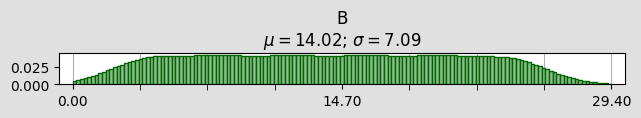
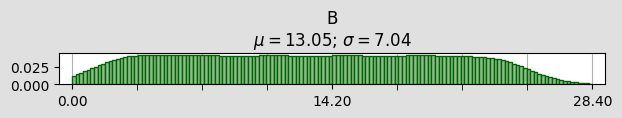
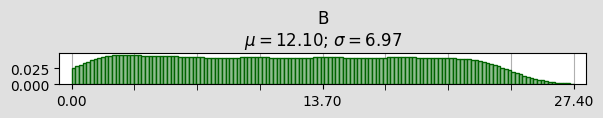

In [9]:
gnb.flow.add_html(cslnb.getCausalModel(cm),"the first causal model")
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getProba(p.extract({'A':v})),f"Doing $A={v}$")
gnb.flow.display()

### If $C$ is cause for $A$, observing $C$ really gives a new information about $B$.


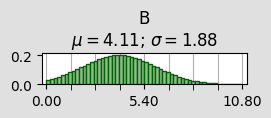
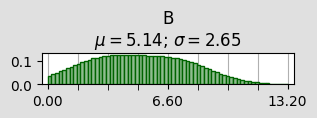
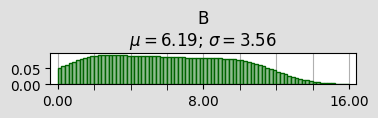

In [10]:
gnb.flow.add_html(cslnb.getCausalModel(cm2),"the second causal model")
for v in [10,20,30]:
  gnb.flow.add_html(gnb.getProba(p2.extract({'A':v})),f"Doing $A={v}$")
gnb.flow.display()

### if $A$ is cause for $C$, observing $C$ may lead to misinterpretations about the causal role of $A$.